In [1]:
import os
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
import pathlib

In [2]:
train_dir = 'chest_xray/train'  # Path to training dataset
val_dir = 'chest_xray/val'      # Path to validation dataset
test_dir = 'chest_xray/test'    # Path to test dataset

# Detect class names from the training directory
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.is_dir()]))
print("Classes detected:", class_names)

for c in class_names:
    count = len(list(pathlib.Path(train_dir).glob(f'{c}/*.jpeg')))
    print(f'{c}: {count} images')

Classes detected: ['NORMAL' 'PNEUMONIA']
NORMAL: 1341 images
PNEUMONIA: 3875 images


In [3]:
batch_size = 32
img_size = 299  # For Inception v3 minimum size

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")


Train size: 5216, Val size: 47, Test size: 624


In [4]:
num_classes = len(class_names)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained Inception v3 (closest in PyTorch)
model = models.inception_v3(pretrained=True)

# Replace the final classification layer
# Inception v3 has AuxLogits and final fc layer
model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)


c:\Users\miraz\OneDrive\Documents\GitHub\Chest-X-Ray-Detection\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\miraz\OneDrive\Documents\GitHub\Chest-X-Ray-Detection\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_one_epoch(epoch, model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, aux_outputs = model(inputs) if model.training else (model(inputs), None)
        
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels) if aux_outputs is not None else 0
        loss = loss1 + 0.4 * loss2

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if isinstance(outputs, tuple):
                outputs = outputs[0]
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc



In [6]:
n_epochs = 10
for epoch in range(n_epochs):
    train_loss, train_acc = train_one_epoch(epoch, model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)
    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}; Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")


Epoch 1: Train Loss 0.4823, Train Acc 0.8566; Val Loss 0.4323, Val Acc 0.7234
Epoch 2: Train Loss 0.4466, Train Acc 0.8660; Val Loss 0.6923, Val Acc 0.7447
Epoch 3: Train Loss 0.3604, Train Acc 0.8974; Val Loss 0.2049, Val Acc 0.8936
Epoch 4: Train Loss 0.3238, Train Acc 0.9051; Val Loss 0.4060, Val Acc 0.8298
Epoch 5: Train Loss 0.3268, Train Acc 0.9015; Val Loss 0.2813, Val Acc 0.8511
Epoch 6: Train Loss 0.2950, Train Acc 0.9132; Val Loss 0.2314, Val Acc 0.9149
Epoch 7: Train Loss 0.2942, Train Acc 0.9191; Val Loss 0.7071, Val Acc 0.8085
Epoch 8: Train Loss 0.2798, Train Acc 0.9218; Val Loss 0.2175, Val Acc 0.9149
Epoch 9: Train Loss 0.2600, Train Acc 0.9239; Val Loss 0.2757, Val Acc 0.9149
Epoch 10: Train Loss 0.2522, Train Acc 0.9304; Val Loss 0.3414, Val Acc 0.7872


In [7]:
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.4017, Test Accuracy: 0.8670


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.65      0.79       234
   PNEUMONIA       0.83      0.99      0.90       390

    accuracy                           0.87       624
   macro avg       0.91      0.82      0.85       624
weighted avg       0.89      0.87      0.86       624



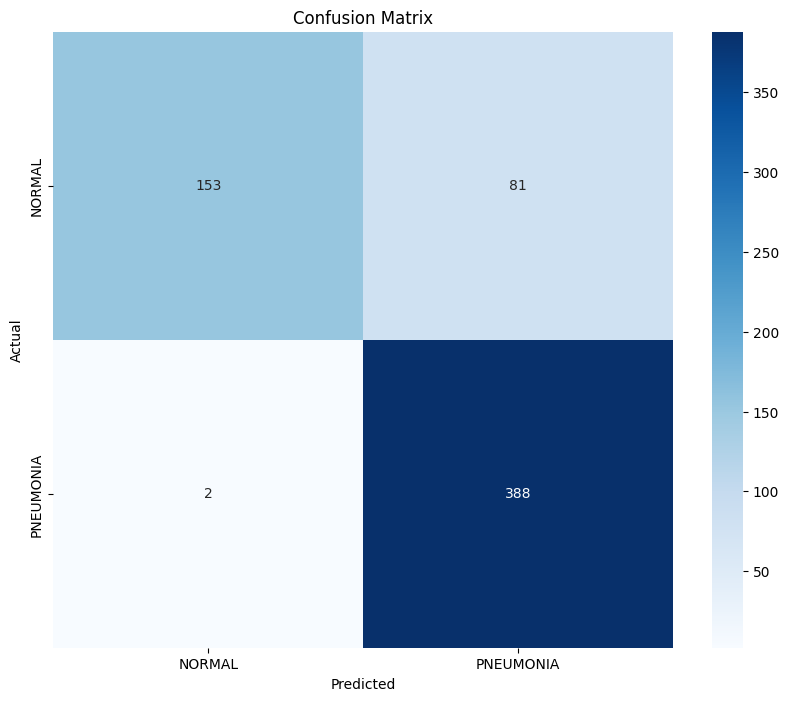

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Get predictions for classification report and confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=test_dataset.classes, 
            yticklabels=test_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


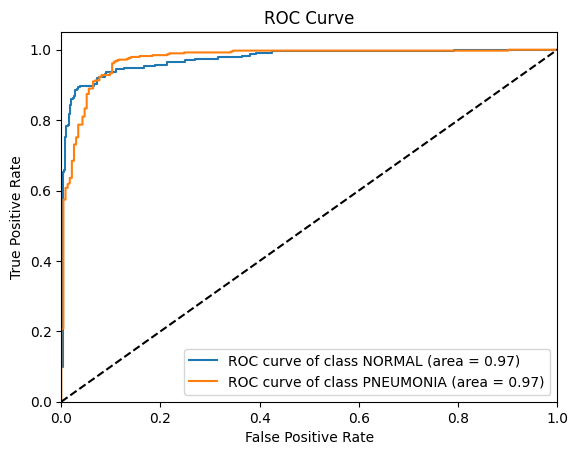

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

model.eval()

all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # for Inception models
        probs = nn.functional.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())  # Collect probabilities
        all_labels.extend(labels.cpu().numpy())  # Collect true labels

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

n_classes = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [10]:
# Save the trained model
torch.save(model.state_dict(), 'inception_v3_model.pth')
print("Model saved as 'inception_v3_model.pth'")

# Optionally, save the entire model (including architecture)
torch.save(model, 'inception_v3_complete_model.pth')
print("Complete model saved as 'inception_v3_complete_model.pth'")


Model saved as 'inception_v3_model.pth'
Complete model saved as 'inception_v3_complete_model.pth'
